Import pakages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob,pandas,time,os

import torch,torchvision
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torcheval.metrics.functional import r2_score,mean_squared_error

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

2.0.0+cu117
True
11.7
8500
cuda


Some Utilities

Dataset

In [3]:
class MyDataSet(Dataset):
    def __init__(self,file_paths,labels_lists,transform):
        super().__init__()
        self.file_paths = file_paths
        self.labels_lists = labels_lists
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image = Image.open(self.file_paths[index])
        image = self.transform(image).float()
        labels = self.labels_lists[index]
        labels = np.array(labels)
        labels = labels.astype('float').reshape(-1,4)
        sample = {'image':image,'psi':labels}
        return sample

DataLoader

In [4]:
def BuildDataLoader(images_fp,labels_fp,config,RGB_mean=(0.485, 0.456, 0.406),RGB_std=(0.229, 0.224, 0.225)):
    df = pandas.read_csv(labels_fp)
    df = df.iloc[:,20:24]
    psi = df.to_numpy()
    img_pl = glob.glob(images_fp)
    img_pl = np.array(img_pl)

    #shuffle
    orig_dataset = np.c_[img_pl,psi]
    np.random.seed(config['random_seed'])
    np.random.shuffle(orig_dataset)

    #split into train and test
    train_inputs, validation_inputs, test_inputs = [],[],[]
    train_labels, validation_labels, test_labels = [],[],[]
    train_num = int(len(orig_dataset)*0.6)
    val_num = int(len(orig_dataset)*0.8)
    for data in orig_dataset[:train_num]:
        train_inputs.append(data[0])
        train_labels.append([data[1:]])
    for data in orig_dataset[train_num:val_num]:
        validation_inputs.append(data[0])
        validation_labels.append([data[1:]])
    for data in orig_dataset[val_num:]:
        test_inputs.append(data[0])
        test_labels.append([data[1:]])

    input_size = config['input_size'][1]
    # normalize = torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    normalize = torchvision.transforms.Normalize(mean = RGB_mean.tolist(), std = RGB_std.tolist())
    data_transforms = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ]),
        'val': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ]),
        'test': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ])
    }

    train_dataLoader = DataLoader(MyDataSet(train_inputs,train_labels,data_transforms['train']),batch_size=config['batch_size'],shuffle=True)
    validation_dataLoader = DataLoader(MyDataSet(train_inputs,train_labels,data_transforms['val']),batch_size=config['batch_size'],shuffle=True)
    test_dataLoader = DataLoader(MyDataSet(test_inputs,test_labels,data_transforms['test']),batch_size=1,shuffle=False)
    
    return train_dataLoader,validation_dataLoader,test_dataLoader


In [5]:
def params_to_update(model:nn.Module)->list:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
    return params_to_update

Train Validation Test

In [6]:
#Validation
def validation(validation_dataLoader:DataLoader,model:torch.nn.Module,criterion,device:torch.device):
    model.eval()
    loss = []
    for _, sample in enumerate(validation_dataLoader) :
        x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
        with torch.no_grad():
            predict = model(x)
            loss.append(criterion(predict,y).detach().cpu().item())
    return loss


In [7]:
#Train
def train(train_dataLoader:DataLoader,validation_dataLoader:DataLoader,model:torch.nn.Module,config,device:torch.device):
    max_epochs = config['max_epochs']
    params_to_update_list = params_to_update(model)
    optimizer = getattr(torch.optim,config['optimizer'])(params_to_update_list,**config['optim_hparas'])   # Setup optimizer
    criterion = getattr(torch.nn,config['lossFunc'])(**config['loss_hparas'])                           # Setup criterion

    min_loss = 1000.
    loss_record = {'train':[],'validation':[]}
    early_stop_cnt = 0
    for epoch in range(max_epochs):
        start_time = time.time()        
        model.train()                       # set model to training mode
        for _, sample in enumerate(train_dataLoader) :
            x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
            optimizer.zero_grad()           # set gradient to zero
            x,y =x.to(device),y.to(device)  # move data to device (cpu/cuda)
            predict = model(x)              # forward pass (compute output)
            loss = criterion(predict,y)     # forward pass (compute output)
            loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                # update model with optimizer
            loss_record['train'].append(loss.detach().cpu().item())
            # loss_record['train'].append(loss.item())

        # After each epoch, test your model on the validation (development) set.
        validation_loss = validation(validation_dataLoader,model,criterion,device)
        epoch+=1
        loss_record['validation'].extend(validation_loss)
        mean_loss = np.mean(validation_loss)
        if mean_loss < min_loss:
            #save model
            min_loss = mean_loss
            end_time = time.time()
            print('Saving model (epoch = {:4d}, loss = {:.4f} Cost {:.3f}(secs))'.format(epoch,mean_loss,(end_time - start_time)))
            torch.save(model.state_dict(),config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt+=1
            if early_stop_cnt > config['early_stop']:
                break
    print('Finished training after {} epochs'.format(epoch))
    return min_loss,loss_record

In [8]:
#Test
def test(test_dataLoader:DataLoader,model:torch.nn.Module,device:torch.device):
    model.eval()
    predict = []
    target = []
    for _, sample in enumerate(test_dataLoader) :
        x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
        with torch.no_grad():
            pred = model(x)
            predict.append(pred.detach().cpu())
            target.append(y.detach().cpu())
    predict = torch.cat(predict,dim=0)
    target = torch.cat(target,dim=0)
    R2 = r2_score(predict,target)
    MSE = mean_squared_error(predict,target)
    return R2,MSE


In [9]:
def getMeanStd(train_fp):
    if not os.path.exists(train_fp):
        return (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)
    # train_fp = "../01DataPreProcessing/crop_img/"
    RGB_mean = torch.tensor([0,0,0],dtype=torch.float32)
    RGB_std = torch.tensor([0,0,0],dtype=torch.float32)
    transform = torchvision.transforms.ToTensor()
    n = 0
    for fp in glob.glob(train_fp+"*.jpg"):
        with Image.open(fp) as img:
            img = transform(img)
            RGB_mean += img.mean(dim=(1,2))
            RGB_std += img.std(dim=(1,2))
            n+=1
    RGB_mean /= n
    RGB_std /= n
    return RGB_mean,RGB_std

Plot

In [10]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['validation'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

Model

In [11]:
class MyResNet(nn.Module):
    def __init__(self,pre_trained_model:torchvision.models.ResNet):
        super(MyResNet,self).__init__()
        #3*488*488 -> 24*244*244
        #If Conv2d comes with BatchNorm, the bias should be set to False.
        self.beforemodel = nn.Sequential(nn.Conv2d(3,24,kernel_size=(3,3),stride=(2,2),padding=(1,1), bias=False)
                                         ,nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                                         ,nn.ReLU())
        self.model = pre_trained_model
        #(凍結參數,False)
        for param in self.model.parameters():
            # param.requires_grad = False
            param.requires_grad = True
        self.model.conv1 = nn.Sequential(nn.Conv2d(24,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
        self.model.fc = torch.nn.Sequential(torch.nn.Linear(in_features=512,out_features=128),torch.nn.LeakyReLU()
                                            ,torch.nn.Linear(in_features=128,out_features=4),torch.nn.LeakyReLU())

    def forward(self,x):
        x = self.beforemodel(x)
        x = self.model(x)
        return x
        

In [12]:
myResNet = MyResNet(torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT))
myResNet = myResNet.to(device)
params = params_to_update(myResNet)
model = myResNet

Hyper-parameters

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('./models/',exist_ok=True)
target_only = False

config ={
    'imput_filepath':'../01DataPreProcessing/aug_images_centerCrop/',
    'input_size':(3,488,488),
    'random_seed':98,
    'max_epochs':2,
    'batch_size':1,
    # 'optimizer':'SGD',
    # 'optim_hparas':{
    #     'lr':0.001,
    #     'momentum':0.8
    # },
    'optimizer':'Adam',
    'optim_hparas':{
        'lr':1e-2,
        'betas':(0.9, 0.999),
        'eps':1e-8,
        'weight_decay':0
    },
    'lossFunc':'MSELoss',
    'loss_hparas':{},
    'early_stop':10,
    'save_path':'./models/model_with_preCov2d_488_img_aug.pth'
}

Main

In [14]:
summary(model,config['input_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 244, 244]             648
       BatchNorm2d-2         [-1, 24, 244, 244]              48
              ReLU-3         [-1, 24, 244, 244]               0
            Conv2d-4         [-1, 64, 122, 122]          75,264
       BatchNorm2d-5         [-1, 64, 122, 122]             128
              ReLU-6         [-1, 64, 122, 122]               0
         MaxPool2d-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11           [-1, 64, 61, 61]          36,864
      BatchNorm2d-12           [-1, 64, 61, 61]             128
             ReLU-13           [-1, 64, 61, 61]               0
       BasicBlock-14           [-1, 64,

Get Mean&STD for normalization

In [18]:
RGB_mean,RGB_std = getMeanStd(config['imput_filepath'])

Build DataLoader

In [24]:
train_dataLoader,validation_dataLoader,test_dataLoader = BuildDataLoader("../01DataPreProcessing/aug_images_centerCrop/*.jpg","../01DataPreProcessing/ftt_psi_10.csv",config,RGB_mean,RGB_std)

Training

In [25]:
min_loss,loss_record = train(train_dataLoader,validation_dataLoader,model,config,device)

Saving model (epoch =    1, loss = 0.2348 Cost 1360.099(secs))


KeyboardInterrupt: 

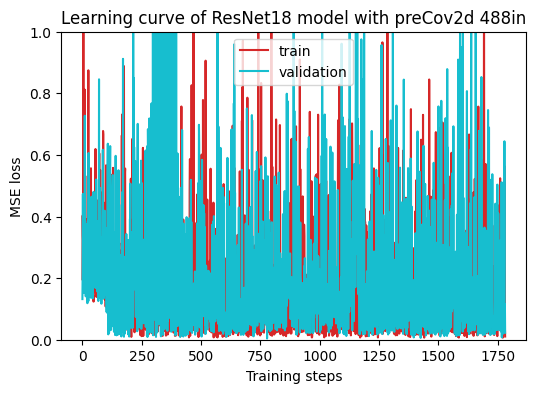

In [54]:
plot_learning_curve(loss_record, title='ResNet18 model with preCov2d 488in')

In [57]:
model.load_state_dict(torch.load(config['save_path'],map_location=torch.device('cpu')))
R2score,mse = test(test_dataLoader,model,device)

In [58]:
print(R2score.item()) # -infinite ~ 1
print(mse.item())

0.00153331458568573
0.13730505108833313
